# Moving average followed by downsampling

This notebook provide an analysis of frequently used low-pass filter, the moving average one, followed by a downsampler (also know as decimator).  

Let's suppose we have a discrete signal $x[n]$ with a certain frequency $ f$<sub>x</sub>  and we want to low-pass filter it and, at the same time, to reduce its frequency by a factor $ k $, obtaining a new signal $ y[n] $ with frequency $ f $<sub>y</sub> $=f$<sub>x</sub>$/k $.  
This result could be obtained by cascading a low-pass filter and a downsampler.

The downsampler simply selects one sample every $kth$ of them, discarding all the unused $k-1$ samples of the input signal (without zero-padding, just holding the last value put in output), thus reducing the frequency of the original signal.  
The downsampling operation can be written down as follow:

$$
  y_d[n] = x[nk+(k−1)]
$$

[The spectrum of the input signal is modified as described in this paper.](https://www.dsprelated.com/freebooks/sasp/Upsampling_Downsampling.html)  

Thus, the frequency axis is expanded by the factor $ k$, wrapping $ k$ times around the unit circle, adding to itself $ k$ times.

Proper decimation involves a digital low-pass filter in order to eliminate all components above $π/k$ (or $f_s/(2k$) ) since these components cannot be represented at the new lower sampling frequency (and will result in aliasing).
As alredy discussed and for the above mentioned purpose, we are going to place a moving average filter as first stage, whose discrete differences equation is the following (a rectangular window):


\begin{equation*}
 y_a[n]  = \frac{1}{k} \left( \sum_{i=n-k+1}^n x[i] \right) 
\end{equation*}

Note that this is a causal filter because it uses only past samples to process the output or equivalently the impulse response of the filter is a single sided function, not equal to zero only for positive samples and in the origin (so its convolution with an input signal will take into account only the current value and the past ones, due to the flipping of $h(t)$). 

Follow a computation of the standard moving average filter (all zeros filter, FIR, BIBO stable) for $k$ (number of averaged samples) varying between 1 and 10. We can see that the reply is what is known in literature as the aliased sinc or asinc function [math demonstration](https://ccrma.stanford.edu/~jos/sasp/Rectangular_Window.html), with a main lobe and, for $k > 2$ some sidelobes zero crossing for $k$ * f_normalized = an integer number.


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

C:\Users\mauri\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


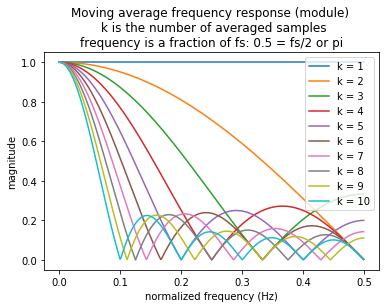

In [2]:
from scipy import signal

fs = 1   # 1Hz samples (so that we can think the x axis as a fraction of fs or 2*pi)

for k in range(0,10):
    w, h = signal.freqz(1/(k+1) * np.ones(k+1), 1)
    plt.plot((fs/2)*(w/np.pi), abs(h), label='k = ' + str(k+1));

plt.title("Moving average frequency response (module) \n k is the number of averaged samples\nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

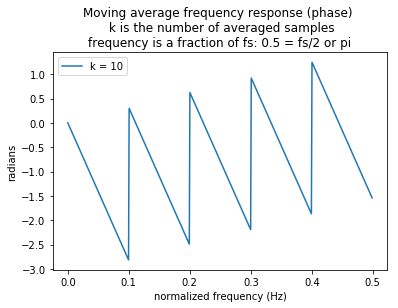

In [3]:
plt.plot((fs/2)*(w/np.pi), np.angle(h), label='k = ' + str(k+1));

plt.title("Moving average frequency response (phase) \n k is the number of averaged samples\nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("radians");
plt.legend();

As visible in the above picture, the response in low-pass in general.  
The main lobe has a width 2pi/k. For k=2 there's only the main lobe of width pi. For k > 2 sidelobes appear: the so called ripple in frequency domain.  
It's interesting that when k is even, the aplitude at Nyquist's frequency is 0, when odd is 1/N.

Note that the fase is not a rectangular 0-pi graph, because the window is not time-centered at 0, so is not purely real.

We are interesting in study how the moving average filter response will be modified downstream the downsampler.

C:\Users\mauri\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


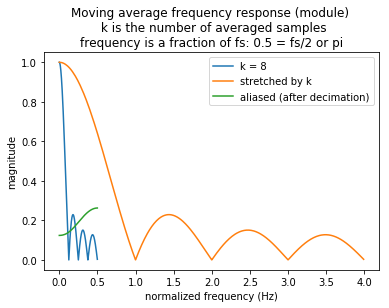

In [4]:
from scipy import signal

fs = 1   #1Hz samples (so that we can think the x axis as a fraction of fs or 2*pi)

k = 7  # decimation factor = k+1 
nas = k+1 # number of averaged samples. It's possible to make this parameter independent from k 

w, h = signal.freqz(1/(nas) * np.ones(nas), 1)
plt.plot((fs/2)*(w/np.pi), abs(h), label='k = ' + str(k+1));

# stretching operation
w_s = np.linspace(0, (k+1)*w.max(), (k+1)*w.size)
h_s = np.zeros((k+1)*h.size, dtype=complex)

for i in range(0, w_s.size):
    h_s[i]=np.interp(w_s[i]/(k+1), w, h)

plt.plot((fs/2)*(w_s/np.pi), abs(h_s), label='stretched by k');

# aliasing operation, implement folding (frequency spectrum folds as an accordion)
h_a = np.zeros(h.size, dtype=complex)
 
for i in range(0, k+1):
    if (i % 2 != 0): # odd: the band is aliased in reversed way 
        h_a = h_a + np.flip(h_s[i*h_a.size:(i+1)*h_a.size],0)
        #h_a = h_a + np.zeros(h_a.size)
    else: #even: the band is directly aliased
        h_a = h_a + h_s[i*h_a.size:(i+1)*h_a.size]
        #h_a = h_a + np.zeros(h_a.size)

# divide by the decimation factor
h_a = (1/(k+1)) * h_a

plt.plot((fs/2)*(w/np.pi), abs(h_a), label='aliased (after decimation)');
        
plt.title("Moving average frequency response (module) \n k is the number of averaged samples\nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

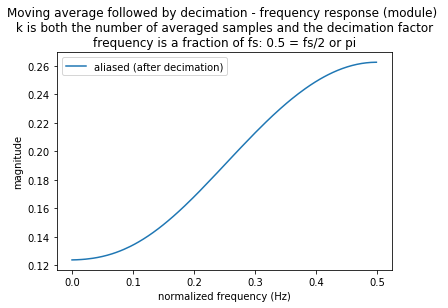

In [5]:
plt.plot((fs/2)*(w/np.pi), abs(h_a), label='aliased (after decimation)');
        
plt.title("Moving average followed by decimation - frequency response (module) \n k is both the number of averaged samples and the decimation factor \nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

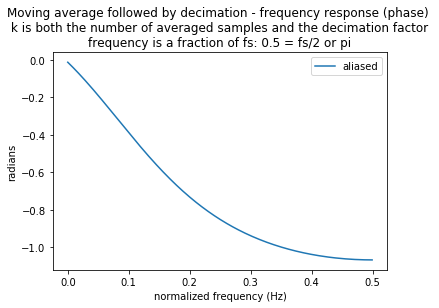

In [6]:
plt.plot((fs/2)*(w/np.pi), np.angle(h_a), label='aliased');

plt.title("Moving average followed by decimation - frequency response (phase) \n k is both the number of averaged samples and the decimation factor \nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("radians");
plt.legend();

[The overall filter is classified as a polyphase filter bank.](https://www.dsprelated.com/freebooks/sasp/Filtering_Downsampling.html)

# Practical considerations

Let's assume we've implemented this kind of filtering with N=8, both for averaging and for decimating.
The real amplitude response will be the one computed above. It's an high-pass filter with amplitude 1/N for f=0 and 1/(N/2) for f=fs/2.

How this can be easily interpreted?

Let's reply by examples:

For f=0, is clear that DC component will pass, as is: the sum of N equal samples it's divided by N, obtaining the original constant value. This explain 1/N.

For f=fs/2, imagine you're sampling a sinusoid with f=fs/2 (so your sampling frequency is fs). You will always acquire two points of the sinusoid in opposition of phase (180° phase shift beetween them). So, if you sum up N of them and then you'll divide by N/2, you're getting 2 times the average value (a gain of 2).
Note that the instant you start sampling, it counts! Or we can say that the phase of the sinusoid will make the difference on the results. In fact this is a multirate filter and for such a filter the Z-transform does not apply in a classical way (ref. https://www.dsprelated.com/showarticle/143.php ). Why? Because it's NOT TIME-INVARIANT!

Finally, for f=fs, what will happen? you'll always sample the same point of the sinusoid (depending on the phase), so you can't distinguish between such a frequency and a DC components. Remember the fact that the DTFT of a real function (and this is the case) has for magnitude response diagram an even (simmetric respect to the y axis) function and the 2*pi-periodicity (or in our x axys the 1- periodicity) of the DTFT? Try to draw the magnitude response for the frequencies between 0.5 and 1.0 and...yes, we're assisting the aliasing effect, where the 0.5 - 1 portion of the magnitude response folds back on the 0 - 0.5 segment.

This is why in embedded systems an hardware anti-aliasing (low-pass) filter is practically always required!
